# Shizhong's original code without modifications

In [1]:
#new lines
load("p1.rda")

In [2]:
library("glmnet")
library("e1071")
library("doParallel")
source("model.R")

args = commandArgs(trailingOnly=TRUE)

set.seed(2018)
wind <- c(5000,10000)
# output directory
#outd <- "/dcl02/lieber/shan/shizhong/finemapping/GWAS/tags/scz3/mwas/chr22/1/"
outd <- "27-OUT/"

# load data for mwas
# load("./rda/caudate_mwas_data_chr22.rda")
#load(as.character(args[2]))
load("BSsample.rda")

# candidate cg
cg <- as.numeric(rownames(p))

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [3]:
# regress out covariates
load("covs_for_meqtl.rda")
mat <- match(BSsample$brnum,colnames(covs)) 
covs <- t(covs[,mat])
p.residual=matrix(0,dim(p)[1],dim(p)[2])
for(i in 1:dim(p)[1]){
	dat <- as.data.frame(cbind(p[i,],covs))
	colnames(dat) <- c("y",paste0("x",1:33))
	model.res <- lm(reformulate(paste0("x",1:33), "y"),dat)
	p.residual[i,] = resid(model.res) 
}

In [4]:
# built predition models
idx.ea <- BSsample$race == "CAUC"
for(k in 1:length(wind)){
models.ea <- c()
models.all <- c()
for(i in 1:length(cg)){
	cat(i,"\n")
	range1 <- ifelse(cg[i] - wind[k] > 0,cg[i] - wind[k],0)
	range2 <- cg[i] + wind[k]
	idx <- map2$POS > range1 & map2$POS < range2
	# go to next cg if no snps within window
	if(sum(idx) <= 1){
		next
	}
	geno <- snp2[idx,]
	rownames(geno) <- map2$POS[idx]
	trainX <- t(geno)
	trainY <- p.residual[i,]
	fit <- tryCatch(
		elastic.net(trainX,trainY),
		error = function(e) {return ("err")})
    if(!is.data.frame(fit)){
        if(fit == "err"){
            next
        }
    }
	fit$cg <- cg[i]	
	models.all <- rbind(models.all,fit)
	# EA only
	trainX <- trainX[idx.ea,]
	if(sum(apply(trainX,2,var)!=0) <= 1){
		next
	}
	trainY <- trainY[idx.ea]	
	fit <- tryCatch(
		elastic.net(trainX,trainY),
		error = function(e) {return ("err")})
    if(!is.data.frame(fit)){
        if(fit == "err"){
            next
        }
    }		
	fit$cg <- cg[i]
	models.ea <- rbind(models.ea,fit)
}
models.ea <- models.ea[models.ea[,1] != "(Intercept)",]
models.all <- models.all[models.all[,1] != "(Intercept)",]

# mwas by models of all samples
cg2 <- unique(models.all$cg)
mwas.all <- matrix(0,nrow=length(cg2),ncol=2)
for(i in 1:length(cg2)){
	pos <- models.all[models.all$cg == cg2[i],1]
	gwas <- snp.gwas2$z[is.element(snp.gwas2$pos_hg38, pos)]
	weight <- models.all[models.all$cg == cg2[i],2]
	geno <- snp.1kg.eur2[match(pos,map.1kg.eur2$POS),]
	mwas.all[i,] <- MWAS(gwas, weight, t(geno))
}
rownames(mwas.all) <- cg2
colnames(mwas.all) <- c("z","p")

# mwas by models of EA samples
cg2 <- unique(models.ea$cg)
mwas.ea <- matrix(0,nrow=length(cg2),ncol=2)
for(i in 1:length(cg2)){
	pos <- models.ea[models.ea$cg == cg2[i],1]
	gwas <- snp.gwas2$z[is.element(snp.gwas2$pos_hg38, pos)]
	weight <- models.ea[models.ea$cg == cg2[i],2]
	geno <- snp.1kg.eur2[match(pos,map.1kg.eur2$POS),]
	mwas.ea[i,] <- MWAS(gwas, weight, t(geno))
}
rownames(mwas.ea) <- cg2
colnames(mwas.ea) <- c("z","p")

# output models and mwas results
outf <- paste0(outd,"/models.all.wind.a27.",wind[k])
write.csv(models.all,outf)
outf <- paste0(outd,"/models.ea.wind.a27.",wind[k])
write.csv(models.ea,outf)
outf <- paste0(outd,"/mwas.all.wind.a27.",wind[k])
write.csv(mwas.all,outf)
outf <- paste0(outd,"/mwas.ea.wind.a27.",wind[k])
write.csv(mwas.ea,outf)
}
	

1 


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


22 
23 
24 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 
56 
57 
58 
59 
60 
61 
62 
63 
64 
65 
66 
67 
68 
69 
70 
71 
72 
73 
74 
75 
76 
77 
78 
79 
80 
81 
82 
83 
84 
85 
86 
87 
88 
89 
90 
91 
92 
93 
94 
95 
96 
97 
98 
99 
100 
101 
102 
103 
104 
105 
106 
107 
108 
109 
110 
111 
112 
113 


Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


114 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -76); Convergence for 76th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


115 


Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -81); Convergence for 81th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -77); Convergence for 77th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


116 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -76); Convergence for 76th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations;

117 


Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; s

118 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -79); Convergence for 79th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -78); Convergence for 78th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -72); Convergence for 72th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; s

119 
120 
121 
122 
123 
124 
125 
126 
127 


Warning message:
“from glmnet C++ code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


128 
129 


Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


130 
131 


Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


132 
133 
134 
135 
136 
137 
138 
139 
140 
141 
142 
143 
144 
145 
146 
147 
148 
149 
150 
151 
152 
153 
154 
155 
156 
157 


Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


158 


Warning message:
“from glmnet C++ code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; s

159 


Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -77); Convergence for 77th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


160 


Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -81); Convergence for 81th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations;

161 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations;

162 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; s

163 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; s

164 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; s

165 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; s

166 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iteration

167 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterati

168 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations;

169 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


170 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


171 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


172 


Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


173 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


174 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


175 


Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


176 
177 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


178 


Warning message:
“from glmnet C++ code (error code -84); Convergence for 84th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


179 
180 
181 
182 
183 
184 
185 
186 
187 
188 
189 
190 
191 
192 
193 
194 
195 
196 
197 
198 
199 
200 
201 
202 
203 
204 
205 
206 
207 
208 
209 
210 
211 
212 
213 
214 
215 
216 
217 
218 
219 
220 
221 
222 
223 
224 
225 
226 
227 
228 
229 
230 
231 
232 
233 
234 
235 
236 
237 
238 
239 
240 
241 
242 
243 
244 
245 
246 
247 
248 
249 
250 
251 
252 
253 
254 
255 
256 
257 
258 
259 
260 
261 
262 
263 
264 
265 
266 
267 
268 
269 
270 
271 
272 
273 
274 
275 
276 
277 
278 
279 
280 
281 
282 
283 
284 
285 
286 
287 
288 
289 
290 
291 
292 
293 
294 
295 
296 
297 
298 
299 
300 
301 
302 
303 
304 
305 
306 
307 
308 
309 
310 
311 
312 
313 
314 
315 
316 


Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


317 
318 
319 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


320 


Warning message:
“from glmnet C++ code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


321 
322 
323 


Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


324 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -73); Convergence for 73th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


325 


Warning message:
“from glmnet C++ code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -66); Convergence for 66th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


326 


Warning message:
“from glmnet C++ code (error code -67); Convergence for 67th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


327 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -70); Convergence for 70th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -80); Convergence for 80th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -76); Convergence for 76th lambda value not reached after maxit=100000 iterations;

328 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -74); Convergence for 74th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -78); Convergence for 78th lambda value not reached after maxit=100000 iterations; s

329 


Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations;

330 


Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations;

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 


Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


29 
30 


Warning message:
“from glmnet C++ code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


31 


Warning message:
“from glmnet C++ code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


32 
33 
34 
35 
36 
37 
38 


Warning message:
“from glmnet C++ code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


39 
40 
41 
42 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 
56 
57 
58 
59 
60 
61 
62 
63 
64 
65 
66 
67 
68 
69 
70 
71 
72 
73 
74 
75 
76 
77 
78 
79 
80 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


81 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


82 
83 
84 
85 
86 
87 
88 
89 
90 
91 
92 
93 
94 
95 
96 
97 
98 
99 
100 
101 
102 
103 
104 
105 
106 
107 
108 
109 
110 
111 
112 
113 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -78); Convergence for 78th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


114 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations;

115 


Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -81); Convergence for 81th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -67); Convergence for 67th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -72); Convergence for 72th lambda value not reached after maxit=100000 iterations; s

116 


Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -77); Convergence for 77th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -77); Convergence for 77th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


117 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; s

118 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations;

119 


Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; s

120 


Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


121 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


122 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -84); Convergence for 84th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


123 


Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -76); Convergence for 76th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -79); Convergence for 79th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


124 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations;

125 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iteration

126 


Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; s

127 


Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iteration

128 


Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations;

129 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iteration

130 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -89); Convergence for 89th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations;

131 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations;

132 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iteration

133 


Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


134 
135 


Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


136 
137 
138 
139 
140 
141 
142 
143 
144 
145 
146 
147 
148 
149 
150 
151 
152 
153 
154 
155 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


156 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


157 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iteration

158 


Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations;

159 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; s

160 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; s

161 


Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; s

162 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -81); Convergence for 81th lambda value not reached after maxit=100000 iterations; s

163 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iteration

164 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations;

165 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations;

166 


Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -81); Convergence for 81th lambda value not reached after maxit=100000 iterations;

167 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; s

168 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations;

169 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


170 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations;

171 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; s

172 


Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -73); Convergence for 73th lambda value not reached after maxit=100000 iterations; s

173 


Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


174 


Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -90); Convergence for 90th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


175 
176 


Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


177 


Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


178 


Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


179 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


180 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


181 


Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


182 
183 
184 
185 
186 
187 
188 
189 
190 
191 
192 
193 
194 
195 
196 
197 
198 
199 
200 
201 
202 
203 
204 
205 


Warning message:
“from glmnet C++ code (error code -83); Convergence for 83th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


206 


Warning message:
“from glmnet C++ code (error code -84); Convergence for 84th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


207 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -80); Convergence for 80th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


208 


Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


209 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


210 
211 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


212 


Warning message:
“from glmnet C++ code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


213 


Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


214 


Warning message:
“from glmnet C++ code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


215 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


216 
217 
218 
219 
220 
221 
222 
223 
224 
225 
226 
227 
228 
229 
230 
231 
232 
233 
234 
235 
236 
237 
238 
239 
240 
241 
242 
243 
244 
245 
246 
247 
248 
249 
250 
251 
252 
253 
254 
255 
256 
257 
258 
259 
260 
261 
262 
263 
264 
265 
266 
267 
268 
269 
270 


Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


271 
272 
273 
274 
275 
276 
277 
278 
279 
280 
281 
282 
283 
284 
285 
286 
287 
288 
289 
290 
291 
292 
293 
294 
295 
296 
297 
298 
299 
300 
301 
302 
303 
304 
305 
306 
307 
308 
309 
310 
311 
312 
313 
314 
315 
316 
317 


Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


318 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


319 
320 


Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


321 


Warning message:
“from glmnet C++ code (error code -85); Convergence for 85th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -86); Convergence for 86th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


322 


Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


323 


Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


324 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


325 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations;

326 


Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -82); Convergence for 82th lambda value not reached after maxit=100000 iteration

327 


Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; s

328 


Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iteration

329 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -93); Convergence for 93th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations;

330 


Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -95); Convergence for 95th lambda value not reached after maxit=100000 iterations;

In [5]:
mwas.all <- as.data.frame(mwas.all)

In [7]:
mwas.all

,z,p
,<dbl>,<dbl>
1980077,9.928432,3.131394e-23
1980101,9.951571,2.482320e-23
1980129,9.936566,2.886048e-23
1980136,9.942210,2.727100e-23
1980145,9.830371,8.331106e-23
1980179,9.961904,2.237369e-23
1980183,9.833712,8.059191e-23
1980193,9.974177,1.977335e-23
1980205,9.960105,2.278214e-23


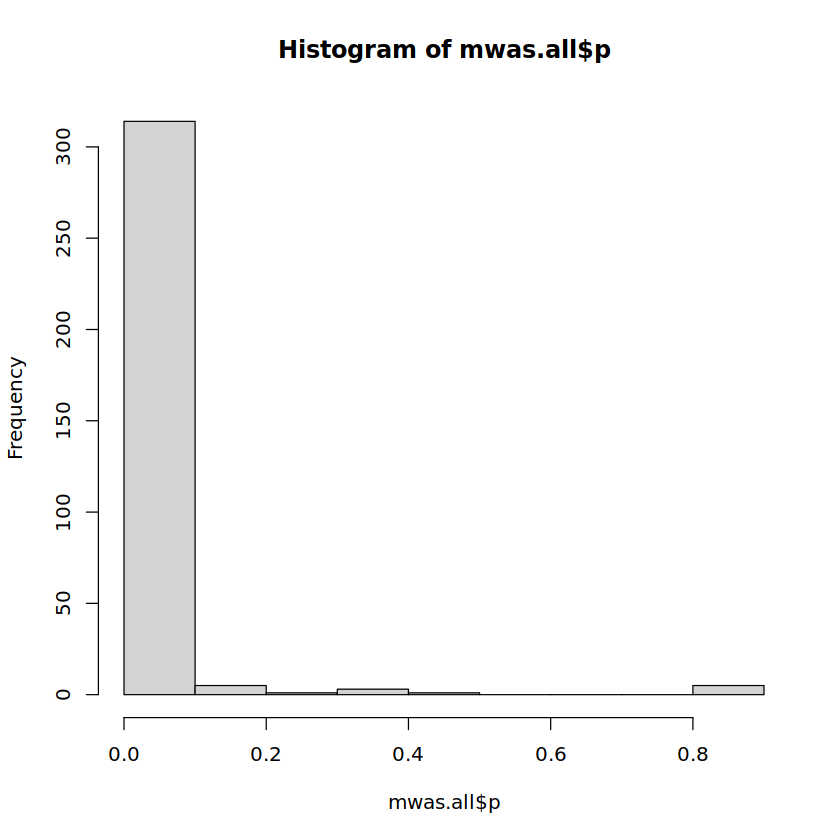

In [6]:
hist(mwas.all$p)